# Predictive Maintenance using Machine Learning on Sagemaker
*Part 1 - Data preparation*

## Initialization
---
Directory structure to run this notebook:
```
sagemaker-predictive-maintenance
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
```

In [1]:
import os
import pandas as pd
import sagemaker
import boto3

## Introduction
---
Imagine you are the manager at a manufacturing company responsible for monitoring assembly lines. Each assembly line contains multiple kinds of machines that must work continuously and reliably to produce ready-to-ship products as can be seen in the image below. IoT sensors placed on these machines monitor electricity consumption, noise generated, vibration, temperature and various other measurable quantities that are used to monitor the health of each machine. Sudden breakdown of any of these machines across multiple assembly lines will lead to:

* Unscheduled downtime and resulting delays in delivering your product to market
* Cost incurred due to delays, and hiring maintenance workers to repair and possibly replace parts of the machine that caused the breakdown

You have been tasked with researching a technique called “predictive maintenance”, especially after your competitors Advantech, Inc. have published a report (http://www.advantech.com/industrial-automation/industry4.0/pms#my_cen). Additionally, you are intrigued to see if Machine Learning can help with this problem. Your team's collective research notes regarding a potential proof-of-concept that you will be building is included here.

## Reactive, Predictive or Preventive Maintenance
---
Maintenance schedules in typical manufacturing and energy companies that involve large number of machines performing tasks are typically a result of “reactive” or “preventive” maintenance. A reactive maintenance task is scheduled if a machine breaks down (or fails), or is operating in a known degrade state of operation. Preventive maintenance is triggered by usage or time or a fixed schedule. As an example, for car owners, reactive maintenance occurs after there is an failure of a component (stalled engine, punctured tire, etc.), whereas preventive maintenance occurs on a fixed schedule (for example, tire rotation or oil change every 10000 miles) even though there may not be a need for doing so.

“Predictive” maintenance implies that maintenance is scheduled when a system predicts the possible occurrence of a failure even in the future. This solves problems that are common in reactive and preventive maintenance - 1. reactive maintenance adds unnecessary time and cost to project schedules, since maintenance workers are deployed only after discovery of a failure event; and 2. preventive maintenance adds unnecessarily frequent maintenance tasks, therefore increasing wait times and costs for the end user. Currently, predictive maintenance techniques involve simple monitoring-and-thresholding, or statistical techniques to identify anomalies from sensor data. However, these techniques are limited to use by Subject Matter Experts (SMEs) and depend on human-generated thresholds. With Machine Learning (ML), it is possible to train models to detect abnormal patterns from sensor data. The trained ML model does not require rules or pre-programmed thresholds, and vast amounts of data can be analyzed repeatably with no need of human involvement.

## NASA Turbofan Engine Fault Dataset
---
### Background

NASA's Prognostic Center of Excellence established a repository with datasets to be used for benchmarking prognostics and predictive maintenance related algorithms. Among these datasets involves data from a turbofan engine simulation model C-MAPPS (or Commercial Modular Aero Propulsion System Simulation). The references section contains details about the over 100 publications using this dataset. C-MAPPS is a tool used to generate health, control and engine parameters from a simulated turbofan engine. A custom code wrapper was used to inject synthetic faults and continuous degradation trends into a time series of sensor data.

<img src="../../common-assets/pictures/turbofan.png" width="640" />

Some high level characteristics of this dataset are as follows:

1. The data obtained is from a **high fidelity simulation** of a turbofan engine, but closely models the sensor values of an actual engine.
2. **Synthetic noise** was added to the dataset to replicate real-world scenarios.
3. The effects of faults are masked due to operational conditions, which is a common trait of most real world systems.

Dataset can be downloaded from here: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan.

In [2]:
ok = True
ok = ok and os.path.exists('../data/interim/train_FD001.txt')
ok = ok and os.path.exists('../data/interim/test_FD001.txt')
ok = ok and os.path.exists('../data/interim/RUL_FD001.txt')
ok = ok and os.path.exists('../data/raw')

if (ok):
    print('Working directories and datasets already exist.')

else:
    print('Some datasets are missing, create working directories and download original dataset from the NASA repository.')
    
    # Making sure the raw data targets already exists:
    os.makedirs('../data/raw', exist_ok=True)
    os.makedirs('../data/interim', exist_ok=True)

    # Download the dataset from the NASA repository, unzip it and set
    # aside the first training file to work on:
    !wget https://ti.arc.nasa.gov/c/6/ --output-document=../data/raw/CMAPSSData.zip
    !unzip ../data/raw/CMAPSSData.zip -d ../data/raw
    
    # Each training / test set is associated to different operating conditions.
    for i in range(1,5):
        !cp ../data/raw/train_FD00$i\.txt ../data/interim/train_FD00$i\.txt
        !cp ../data/raw/test_FD00$i\.txt ../data/interim/test_FD00$i\.txt
        !cp ../data/raw/RUL_FD00$i\.txt ../data/interim/RUL_FD00$i\.txt

Working directories and datasets already exist.


### More details
Datasets consist of multiple **multivariate** time series. Each data set is further divided into training and test subsets. Each time series is from a different engine (`unit number`) i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data (`operational setting 1`, `operational setting 2` and `operational setting 3`). The data (`sensor measurement 1` to `sensor measurement 21`) is contaminated with **sensor noise**.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to **predict the number of remaining operational cycles before failure in the test set**, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1. `unit number`
2. `time, in cycles`
3. `operational setting 1`
4. `operational setting 2`
5. `operational setting 3`
6. `sensor measurement 1`
7. `sensor measurement 2`
8. ...
9. `sensor measurement 21`

### Data ingestion

In [3]:
dataset_path = '../data/interim/train_FD001.txt'
data = pd.read_csv(dataset_path, header=None, sep=' ')
data.dropna(axis='columns', how='all', inplace=True)
print('Shape:', data.shape)
data.head(5)

Shape: (20631, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Setting readable column names:

In [4]:
columns = [
    'unit_number',
    'time',
    'operational_setting_1',
    'operational_setting_2',
    'operational_setting_3',
] + ['sensor_measurement_{}'.format(s) for s in range(1,22)]
data.columns = columns

### Defining RUL target function

Traditionnal way of assigning target values for RUL estimation, applies a linear decrease along with time. This definition implies that the health of a system degrades linearly along with time. In practical applications, degradation of a component is negligible at the beginning of use and increases when component approaches end-of-life. To better model the RUL changes along with time, a piece-wise linear RUL target function is often proposed: for this experiment, we will set the maximum limit to 130 time cycles (value used in several papers: [here](https://www.researchgate.net/publication/224358896_Recurrent_neural_networks_for_remaining_useful_life_estimation) and [there](https://www.researchgate.net/publication/314933361_Deep_Convolutional_Neural_Network_Based_Regression_Approach_for_Estimation_of_Remaining_Useful_Life) for instance).

In [5]:
# Add a RUL column and group the data by unit_number:
data['true_rul'] = 0
data['piecewise_rul'] = 0
grouped_data = data.groupby(by='unit_number')
rul_limit = 130

# Loops through each unit number to get the lifecycle counts:
for unit, max_rul in enumerate(grouped_data.count()['time']):
    current_df = data[data['unit_number'] == (unit+1)].copy()
    current_df['true_rul'] = max_rul - current_df['time']
    current_df.loc[current_df['true_rul'] > 130, 'piecewise_rul'] = 130
    current_df.loc[current_df['true_rul'] <= 130, 'piecewise_rul'] = current_df['true_rul']
    data[data['unit_number'] == (unit+1)] = current_df

We now have a piecewise RUL:

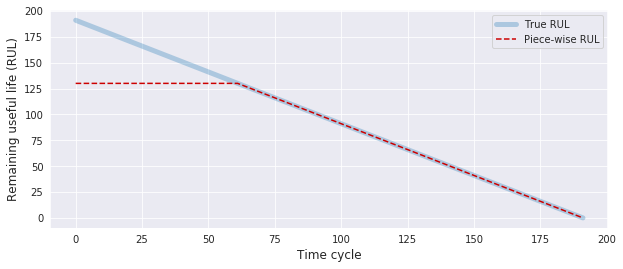

In [6]:
current_df = data[data['unit_number'] == 1]
true_rul = current_df['true_rul']
piecewise_rul = current_df['piecewise_rul']

fig = plt.figure(figsize=(10,4))
ax = true_rul.plot(linestyle='-', linewidth=5, alpha=0.3, label='True RUL')
piecewise_rul.plot(linestyle='--', color='#CC0000', ax=ax, label='Piece-wise RUL')
ax.set_ylabel('Remaining useful life (RUL)', fontsize=12)
ax.set_xlabel('Time cycle', fontsize=12)
plt.legend();

In [7]:
data.head()

,unit_number,time,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,true_rul,piecewise_rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,130
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,130
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,130
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,130
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,130


Adding a column specifying that the engine is near the end of its lifetime: we will use this column as the label for the classification part of the training later on.

In [6]:
low_cycle = 30
data['label'] = data['rul'].apply(lambda x: 1 if x <= low_cycle else 0)
data.head()

,unit_number,time,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,rul,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


## Cleanup
### Storing data for the next notebook

In [7]:
%store -z
%store data
%store columns

Stored 'data' (DataFrame)
Stored 'columns' (list)


### Persisting these data to disk
This is useful in case you want to be able to execute each notebook independantly (from one session to another) and don't want to reexecute every notebooks whenever you want to focus on a particular step.

In [9]:
# Create the local path for our artifacts:
local_path = '../data/interim'
os.makedirs(local_path, exist_ok=True)

# Write the dataframe:
data.to_csv(os.path.join(local_path, 'data.csv'), index=False)

# Write the columns names:
with open(os.path.join(local_path, 'columns.txt'), 'w') as f:
    f.write(','.join(columns))